In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/Shareddrives/CST9-HumanBisyon/MobileNetv2_Classification_Dataset" "/content/MobileNetv2_Classification_Dataset"

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [ ]:
#STEP 1 Import Required Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
#STEP 2 Define dataset paths
BASE_DIR = "/content/MobileNetv2_Classification_Dataset"
TRAIN_DIR = BASE_DIR + "/train"
VAL_DIR   = BASE_DIR + "/val"
TEST_DIR  = BASE_DIR + "/test"

In [ ]:
#STEP 3 Image parameters
IMG_SIZE = (224, 224)   # REQUIRED for MobileNetV2
BATCH_SIZE = 32

In [ ]:
#STEP 4 Data generators (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#STEP 5 Load images from folders
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 4000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)

{'human_faces': 0, 'non_human_faces': 1}


In [ ]:
#STEP 6 Load pretrained MobileNetV2 (Transfer Learning)
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False   # Freeze pretrained layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#STEP 7 Build the classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
#STEP 8 Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
#STEP 9 Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,   # max epochs, early stopping will cut it short
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 94s 611ms/step - accuracy: 0.7866 - loss: 0.4455 - val_accuracy: 0.9780 - val_loss: 0.1106
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 482ms/step - accuracy: 0.9826 - loss: 0.0820 - val_accuracy: 0.9940 - val_loss: 0.0490
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 471ms/step - accuracy: 0.9892 - loss: 0.0495 - val_accuracy: 0.9940 - val_loss: 0.0314
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 479ms/step - accuracy: 0.9960 - loss: 0.0310 - val_accuracy: 0.9960 - val_loss: 0.0258
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - accuracy: 0.9955 - loss: 0.0196 - val_accuracy: 0.9980 - val_loss: 0.0178
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 500ms/step - accuracy: 0.9960 - loss: 0.0184 - val_accuracy: 0.9980 - val_loss: 0.0144
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 467ms/step - accuracy: 0.9949 - loss: 0.0212 - val_accuracy: 0.9960 - val_loss: 0.0140
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 483ms/step - accuracy: 0.9973 - loss: 0

In [ ]:
#STEP 10 Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9937 - loss: 0.0208
Test Accuracy: 0.9980


In [ ]:
#STEP 11 Save the trained model
model.save("/content/mobilenetv2_human_face_classifier.h5")

In [ ]:
#STEP 12 Test on a SINGLE image
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to your test image
img_path = "/content/test-animals.jpg"  # change this

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]

# Convert to percentage
human_percent = (1 - prediction) * 100
non_human_percent = prediction * 100

print(f"Human Face: {human_percent:.2f}%")
print(f"Non-Human Face: {non_human_percent:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Human Face: 9.29%
Non-Human Face: 90.71%


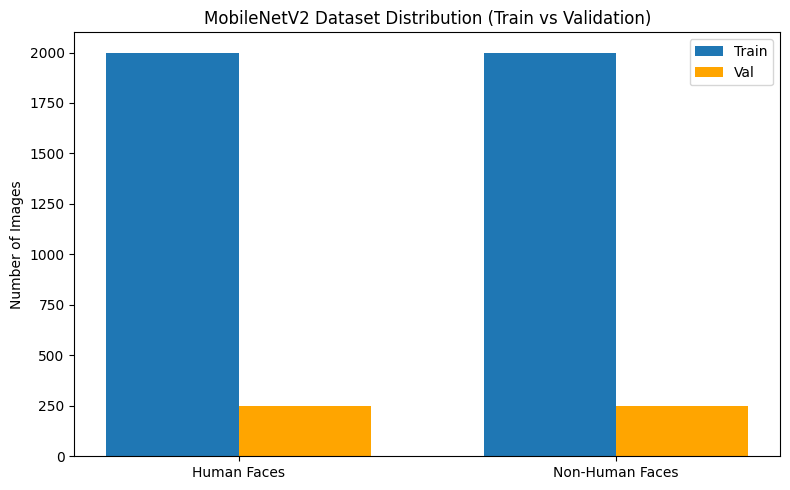

Dataset Image Counts:
train/human_faces: 2000
train/non_human_faces: 2000
val/human_faces: 250
val/non_human_faces: 250


In [ ]:
#Dataset Distribution
import os
import matplotlib.pyplot as plt

# Base dataset path
BASE_PATH = "/content/MobileNetv2_Classification_Dataset"

# Dataset splits and classes
splits = ["train", "val"]
classes = ["human_faces", "non_human_faces"]

# Count images
data_counts = {}

for split in splits:
    data_counts[split] = {}
    for cls in classes:
        folder_path = os.path.join(BASE_PATH, split, cls)
        data_counts[split][cls] = len([
            f for f in os.listdir(folder_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

# Plot setup
labels = ["Human Faces", "Non-Human Faces"]
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

# Train bars (default color)
train_counts = [
    data_counts["train"]["human_faces"],
    data_counts["train"]["non_human_faces"]
]
ax.bar(x, train_counts, width=width, label="Train")

# Val bars (ORANGE)
val_counts = [
    data_counts["val"]["human_faces"],
    data_counts["val"]["non_human_faces"]
]
ax.bar([p + width for p in x], val_counts, width=width, label="Val", color="orange")

# Labels and title
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels)
ax.set_ylabel("Number of Images")
ax.set_title("MobileNetV2 Dataset Distribution (Train vs Validation)")
ax.legend()

plt.tight_layout()
plt.show()

# Save figure
fig.savefig("mobilenetv2_dataset_distribution.png", dpi=300, bbox_inches="tight")

# Print counts
print("Dataset Image Counts:")
for split in splits:
    for cls in classes:
        print(f"{split}/{cls}: {data_counts[split][cls]}")



Found 500 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 967ms/step


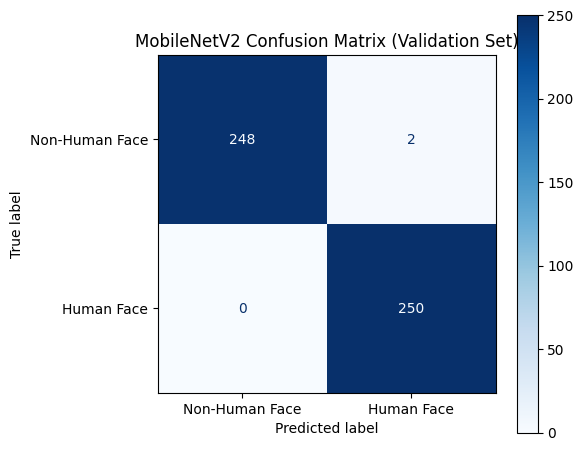

Confusion Matrix:
[[248   2]
 [  0 250]]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Paths
MODEL_PATH = "/content/mobilenetv2_human_face_classifier.h5"
VAL_PATH = "/content/MobileNetv2_Classification_Dataset/val"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load model
model = load_model(MODEL_PATH)

# Validation data generator (NO SHUFFLE)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Get true labels
y_true = val_generator.classes

# Predict
y_pred_probs = model.predict(val_generator)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Human Face", "Human Face"]
)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("MobileNetV2 Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

# Save figure
fig.savefig("mobilenetv2_confusion_matrix.png", dpi=300, bbox_inches="tight")

# Print matrix values
print("Confusion Matrix:")
print(cm)
